In [103]:
import numpy as np
import matplotlib.pyplot as plt

In [104]:
timecalc = 9
tolerance = 1e-7

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [105]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [106]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

1342
(1342,)


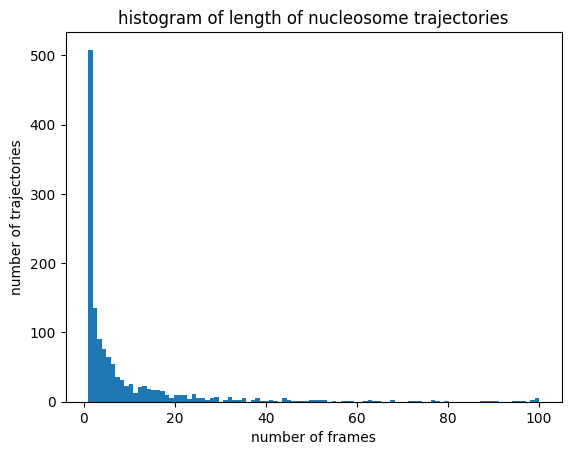

In [107]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

hist = []
print(len(nucleosomes))
for nucleosome in nucleosomes:
    if len(nucleosome.traj) > 0:
        hist.append(len(nucleosome.traj))
    # print(len(nucleosome.traj))

hist = np.array(hist)
print(hist.shape)
plt.hist(hist, bins=max(hist))
plt.title("histogram of length of nucleosome trajectories")
plt.xlabel("number of frames")
plt.ylabel("number of trajectories")
plt.show()

In [108]:
# calculate msd for each trajectory which has more than 20 frames
cutoff = 20
msd = []
selected_p_ind = []
for n in nucleosomes:
    if len(n.traj) > cutoff+10:
        curmsd = np.zeros(cutoff+10)
        traj = n.traj[:cutoff+10]
        for i in range(1, cutoff+10):
            # vectorized
            curmsd[i] = np.sum((traj[i:, 1:3] - traj[0:-i, 1:3])**2) / (cutoff+10 - i)
        msd.append([n.p_ind, curmsd[:cutoff]*4225])    # px^2 to nm^2
        selected_p_ind.append(n.p_ind)
# msd = np.array(msd)
print("msd.shape", len(msd))
print("selected_p_ind.shape", len(selected_p_ind))

msd.shape 89
selected_p_ind.shape 89


/tmp/ipykernel_60627/3819409747.py:6: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(np.arange(0, 1.05, 0.05))
/tmp/ipykernel_60627/3819409747.py:9: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(msd[i][1])   # 4225 nm^2 per pixel^2


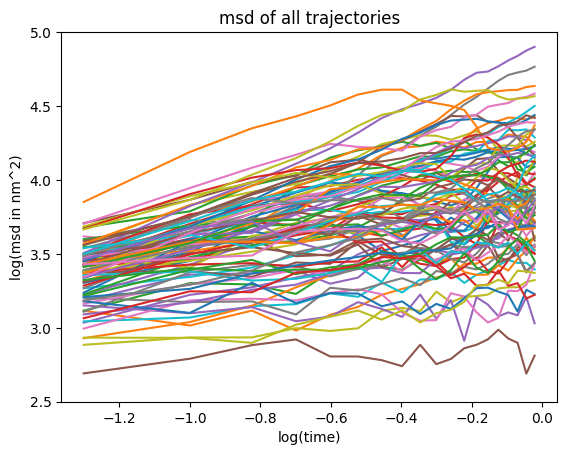

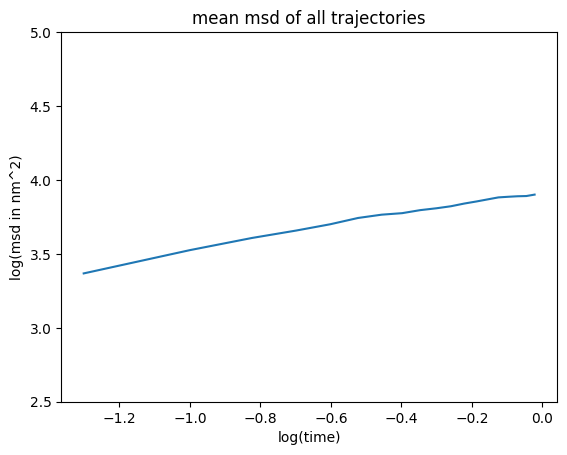

In [109]:
# plot all msd
# y is log of msd
# x is log of time
# np arange 100 frames from 0 s to 5 s
logy = []
x = np.log10(np.arange(0, 1.05, 0.05))
for i in range(len(msd)):
    # if len(msd[i][1]) > 19:
    y = np.log10(msd[i][1])   # 4225 nm^2 per pixel^2
    # y = y[:20]
    logy.append(y)
    # selected_p_ind.append(msd[i][0])
    # plt.plot(msd[i])
    plt.plot(x[:len(y)], y)
plt.title("msd of all trajectories")
plt.xlabel("log(time)")
plt.ylabel("log(msd in nm^2)")
plt.ylim(2.5, 5)
plt.show()

# plot mean msd
logy = np.array(logy)
meany = np.mean(logy, axis=0)
plt.plot(x[:len(meany)], meany)
plt.title("mean msd of all trajectories")
plt.xlabel("log(time)")
plt.ylabel("log(msd in nm^2)")
plt.ylim(2.5, 5)
plt.show()

In [110]:
print(logy.shape)
print(logy)

selected_p_ind = np.array(selected_p_ind)
print(selected_p_ind.shape)
print(selected_p_ind)

(89, 20)
[[      -inf 3.33713641 3.56399606 ... 3.75387039 3.8974728  3.92207296]
 [      -inf 3.11525175 3.0153029  ... 3.50261725 3.61054525 3.52714631]
 [      -inf 3.11572218 3.30224268 ... 3.62545239 3.57591152 3.61013713]
 ...
 [      -inf 3.42907421 3.47175488 ... 3.7925027  3.70508034 3.82821594]
 [      -inf 3.18448978 3.2908982  ... 3.86030116 3.88031437 3.87588724]
 [      -inf 2.93334488 2.93220578 ... 3.38611578 3.38079266 3.37071684]]
(89,)
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30. 130. 131. 132. 177. 178. 179. 203. 232. 233. 255. 263. 264.
 285. 303. 304. 305. 321. 322. 330. 351. 352. 369. 370. 382. 409. 424.
 436. 447. 460. 461. 462. 473. 474. 499. 545. 546. 561. 584. 585. 598.
 611. 622. 654. 683. 748. 755. 778. 787. 824. 825. 842. 874. 885. 886.
 925. 934. 949. 960. 967.]


In [111]:
# go over each selected trajectory and calculate alpha using polyfit
new_traj = np.zeros((len(selected_p_ind)*cutoff, 4))   # x,y,t,alpha
new_traj[:, 2] = np.tile(np.arange(0, 1.0, 0.05), len(selected_p_ind))

alpha_analysis = []

for i in range(len(selected_p_ind)):
    # get the x and y of the p_ind
    p_ind = int(selected_p_ind[i])
    traj = nucleosomes[p_ind-1].traj
    traj = traj[:cutoff]

    new_traj[i*cutoff:(i+1)*cutoff, 0] = traj[:, 1]
    new_traj[i*cutoff:(i+1)*cutoff, 1] = traj[:, 2]

    xfull = np.log10(np.arange(0, 1.05, 0.05))
    # calculate alpha1
    x1 = xfull[1:5]
    y1 = logy[i][1:5]
    alpha1 = 1
    alpha1, D1 = np.polyfit(x1, y1, 1)

    print("alpha1", alpha1)

    # calculate alpha2
    x2 = xfull[5:20]
    y2 = logy[i][5:20]
    alpha2 = 1
    alpha2, D2 = np.polyfit(x2, y2, 1)
    print("alpha2", alpha2)
    print()

    alpha_analysis.append([alpha1, alpha2])

    new_traj[i*cutoff:(i+1)*cutoff, 3] = np.concatenate((np.tile(alpha1, 5), np.tile(alpha2, 15)))

print(new_traj.shape)


alpha1 0.5629021771152594
alpha2 0.41358835685161255

alpha1 -0.1451237958281129
alpha2 0.8417817876189636

alpha1 0.2169505035040086
alpha2 0.49746929328603817

alpha1 0.8207137445690204
alpha2 -0.025606068886119097

alpha1 0.34393589084029086
alpha2 0.6388490451057619

alpha1 0.390647994876945
alpha2 0.1428503989141093

alpha1 0.23008717597886943
alpha2 0.35589412139655036

alpha1 0.6639297928511331
alpha2 1.5271309583540418

alpha1 0.16368487708972146
alpha2 0.5587043362260659

alpha1 0.35471611307365025
alpha2 0.48316350603549224

alpha1 0.7713757296915255
alpha2 -0.22525909013861015

alpha1 0.8860037151492641
alpha2 0.4074821268223367

alpha1 0.5157886631753529
alpha2 0.0903931479870249

alpha1 0.34776448059161524
alpha2 0.0890561681843285

alpha1 0.4968949507198036
alpha2 0.7966077980192126

alpha1 0.15828805280104993
alpha2 0.33113007981710857

alpha1 0.7386854280917249
alpha2 0.047579329734193626

alpha1 0.5414580152502906
alpha2 0.030923816764966503

alpha1 0.6948698285176308


/tmp/ipykernel_60627/4024106663.py:16: RuntimeWarning: divide by zero encountered in log10
  xfull = np.log10(np.arange(0, 1.05, 0.05))


In [112]:
# save the new_traj upto 3 decimal places
np.savetxt("new_traj.txt", new_traj, delimiter="\t", fmt="%.3f")

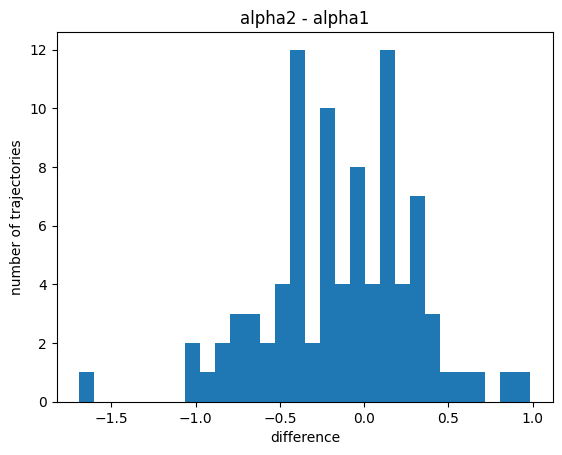

In [113]:
# plot the difference between alpha1 and alpha2
alpha_analysis = np.array(alpha_analysis)
diff = alpha_analysis[:, 1] - alpha_analysis[:, 0]
plt.hist(diff, bins=30)
plt.title("alpha2 - alpha1")
plt.xlabel("difference")
plt.ylabel("number of trajectories")
plt.show()

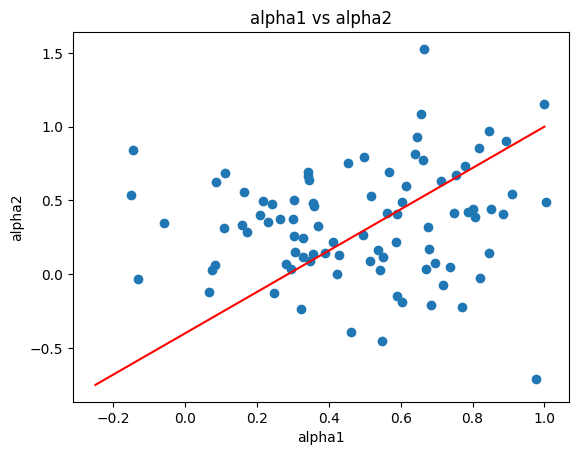

In [118]:
# plot the alpha1 and alpha2
plt.scatter(alpha_analysis[:, 0], alpha_analysis[:, 1])
plt.xlabel("alpha1")
plt.ylabel("alpha2")
plt.title("alpha1 vs alpha2")
# plot x=y line
plt.plot([-0.25, 1], [-0.75, 1], color="red")
plt.show()